## 下载解压图片

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/24stu/肝败下风/* ./

cp: cannot stat '/content/drive/MyDrive/24stu/肝败下风/*': No such file or directory


In [ ]:
!unrar x /content/新建文件夹.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/新建文件夹.rar

Creating    新建文件夹                                                     OK
Extracting  新建文件夹/1.jpeg                                                   0%  OK 
Extracting  新建文件夹/10.jpg                                                   0%  OK 
Extracting  新建文件夹/100.jpg                                                  0%  OK 
Extracting  新建文件夹/101.jpg                                                  1%  OK 
Extracting  新建文件夹/102.jpg                                                  1%  OK 
Extracting  新建文件夹/103.jpg                                                  1%  OK 
Extracting  新建文件夹/104.jpg                                                  1%  OK 
Extracting  新建文件夹/105.jpg                                                  1%  OK 
Extracting  新建文件夹/106.jpg                                                  

# 导入python包

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
import seaborn as sns

from tokenizers import Tokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import  functional as F

from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision


from torchvision import datasets,models

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 超参数定义

In [ ]:

max_len = 40
n_class = 4
train_num = 160
test_num = 40

# 准备数据集

## 生成训练集和测试集

In [ ]:
def get_pic_name(item):
  pic_name = item.split('/')[-1]
  pic_path = '/content/新建文件夹/'+pic_name
  return pic_path

In [ ]:
import json
import re

def get_num_list(json_str):
  # json_str = "{'score': [0.1, 0.7, 0.2]}"
  ori_list = json_str.split('[')[1].split(']')[0].split(',')
  num_list = [float(item) for item in ori_list]
  return num_list



In [ ]:
pd_all = pd.read_csv('/content/新建文件夹/加了score值的表格.csv').sample(frac=1).reset_index(drop=True)
pd_all['label'] = pd_all['label'] - 1
pd_all['pic_path'] = pd_all['pic'].map(get_pic_name)
pd_all['vec'] = pd_all.score.map(get_num_list)
pd_train = pd_all[:160]
pd_test = pd_all[160:]
pd_all

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"
...,...,...,...,...,...,...,...
195,24,/content/24.jpg,0,这张图片中，一位穿蓝色连衣裙的女子正在射击场上学习使用步枪。她背后站着一位穿黑色衣服的教练，...,"{'score':[0.5, 0.4, 0.1]}",/content/新建文件夹/24.jpg,"[0.5, 0.4, 0.1]"
196,113,/content/113.jpg,2,图片中，一个人站在高空的脚手架上，身穿灰色上衣。脚手架结构复杂，周围没有明显的安全措施，显得...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/113.jpg,"[0.05, 0.2, 0.75]"
197,103,/content/103.jpg,2,图片中，一个人悬挂在高层建筑的窗外，双手紧紧抓住窗框，身体悬空。此人穿着深色衣服，脚下没有任...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/103.jpg,"[0.05, 0.1, 0.85]"
198,162,/content/162.jpg,3,这张图片显示了一起交通事故的现场，一辆大巴车与一辆白色轿车相撞，轿车被大巴车压在车轮下，车头...,"{'score':[0.1, 0.1, 0.8]}",/content/新建文件夹/162.jpg,"[0.1, 0.1, 0.8]"


In [ ]:
# pd_all = pd.read_csv('/content/数据集/data.csv',encoding='gbk').sample(frac=1).reset_index(drop=True)
# pd_all['pic_path'] = pd_all['pic'].map(get_pic_name)
# pd_all['vec'] = [[0.5,0.1,0.4]]*len(pd_all)
# pd_train = pd_all[:160]
# pd_test = pd_all[160:]
# pd_all

## 查看图文特征

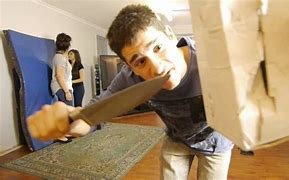

In [ ]:

eg_pic_path = '/content/新建文件夹/91.jpg'
# eg_pic_path = img_dir + '16_05_01_100.jpg'
# 打开图像并加载
img = Image.open(eg_pic_path)
# 显示图像
img

In [ ]:
def get_len(item):
  sen_len = len(item.split(' '))
  return sen_len

In [ ]:
pd_train['len'] = pd_train['text'].map(len)
pd_test['len'] = pd_test['text'].map(len)
pd_train

<ipython-input-12-32410a0d91ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_train['len'] = pd_train['text'].map(len)
<ipython-input-12-32410a0d91ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_test['len'] = pd_test['text'].map(len)


,Unnamed: 0,pic,label,text,score,pic_path,vec,len
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]",90
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]",95
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]",97
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]",97
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]",106
...,...,...,...,...,...,...,...,...
155,164,/content/164.jpg,3,这张图片显示了一辆银色汽车严重撞击电线杆的场景。车头和车顶明显变形，前挡风玻璃破碎。车内有一...,"{'score':[0.1, 0.2, 0.7]}",/content/新建文件夹/164.jpg,"[0.1, 0.2, 0.7]",103
156,12,/content/12.jpg,0,这张图片中，一名身穿迷彩服和头巾的男子正持枪射击。他的武器在射击时产生了火焰和烟雾，背景是一...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/12.jpg,"[0.05, 0.3, 0.65]",106
157,123,/content/123.jpg,2,图片中，一个人正在两栋高楼之间跳跃，动作定格在空中，背景是阴沉的天空。两栋高楼在视野中形成对...,"{'score':[0.7, 0.2, 0.1]}",/content/新建文件夹/123.jpg,"[0.7, 0.2, 0.1]",80
158,67,/content/67.jpg,1,图片展示了一只手握着一把锋利的刀，刀刃朝向前方。持刀者穿着浅色衣服，背景模糊，无法看清具体场...,"{'score':[0.02, 0.08, 0.9]}",/content/新建文件夹/67.jpg,"[0.02, 0.08, 0.9]",86


<Axes: >

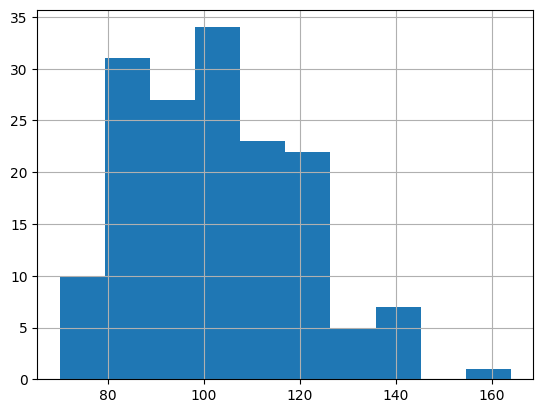

In [ ]:

pd_train['len'].hist()

In [ ]:
pd_train['label'].value_counts()

,count
label,
1,44
3,42
0,37
2,37


In [ ]:
pd_test['label'].value_counts()

,count
label,
0,13
2,13
3,8
1,6


# 确定GPU cpu使用情况

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# 创新模型： vit + bert + clip + att

## 准备训练和测试循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec, y) in enumerate(dataloader):

        x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
        x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
        x_vec = x_vec.to(device)
        pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(x_img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec,  y) in enumerate(dataloader):
            x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
            x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
            x_vec = x_vec.to(device)
            pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## 数据处理和特征工程

### 英文编码tokenizer roberta

In [ ]:
model_name = "bert-base-chinese"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)



NameError: name 'AutoTokenizer' is not defined

In [ ]:
eg_text = '早上好'
eg_result = tokenizer_bert(eg_text, padding='max_length', max_length=25, truncation=True, return_tensors="pt")
eg_result

{'input_ids': tensor([[ 101, 3193,  677, 1962,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
voc_size = tokenizer_bert.vocab_size
voc_size

21128

### clip 文本处理

In [ ]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection

t_clip_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
t_clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# inputs = t_clip_tokenizer(["a photo of a cat", "a photo of a dog"],  return_tensors="pt",max_length=50,padding="max_length",truncation=True)
inputs = t_clip_tokenizer("a photo of a cat",  return_tensors="pt",max_length=50,padding="max_length",truncation=True)

outputs = t_clip_model(**inputs)
text_embeds = outputs.text_embeds

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
text_embeds.shape

torch.Size([1, 512])

In [ ]:
inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
t_clip_model(inputs.input_ids).text_embeds

tensor([[ 1.5546e-01,  7.3294e-02, -2.4484e-01, -2.2115e-01, -1.9344e-01,
          2.0518e-01, -3.1749e-01, -7.8242e-01, -1.8164e-01,  1.9433e-01,
         -7.6181e-02, -6.0524e-01,  1.9231e-01, -1.0163e-01,  1.3738e-01,
          1.3672e-01,  2.4225e-01, -1.7962e-01, -8.8909e-02,  2.8717e-01,
          6.3450e-01,  1.6425e-01,  4.5428e-01, -2.9290e-02, -2.5141e-01,
          1.9239e-01,  2.4865e-01,  6.4663e-01, -2.3520e-01, -2.3172e-01,
          2.2597e-01,  1.8951e-01,  1.5041e-01,  4.8223e-01, -2.1912e-01,
         -1.8246e-01,  2.5335e-01, -2.7369e-02,  2.3673e-01,  2.3744e-01,
         -9.5580e-02, -1.1553e-01,  2.8116e-01,  1.1927e-01,  1.6268e-01,
          8.6734e-02, -2.5180e-01,  3.1935e-02, -5.3379e-02, -1.6613e-01,
          8.5413e-02, -4.0281e-02,  5.2349e-01, -9.5650e-02, -5.3954e-02,
         -2.9765e-01,  4.7326e-02,  2.0898e-01, -5.6442e-02, -3.0747e-02,
          4.5797e-01, -1.1969e-01, -2.9258e-01,  6.0592e-02,  2.1891e-01,
         -2.1244e-01,  3.9416e-02,  2.

### clip 图像处理

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModelWithProjection

img_clip_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
img_clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = img_clip_processor(images=image, return_tensors="pt")

outputs = img_clip_model(**inputs)
image_embeds = outputs.image_embeds

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [ ]:
outputs.image_embeds.shape

torch.Size([1, 512])

In [ ]:
pd_all.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"


### 准备dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer_en):
        self.pd_data = pd_data
        self.text_list = list(pd_data['text'])
        self.label_list = list(pd_data['label'])
        self.img_path_list = list(pd_data['pic_path'])
        self.vec_lists = list(pd_data['vec'])
        self.tokenizer = tokenizer_en
        self.t_clip_tokenizer = t_clip_tokenizer
        self.img_clip_processor = img_clip_processor

    def __len__(self):
        return len(self.pd_data)

    def __getitem__(self, idx):


        # 文本数据处理
        one_text = self.text_list[idx]
        one_text_array = self.tokenizer(one_text, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")['input_ids'][0]
        one_clip_text = self.t_clip_tokenizer(one_text,  return_tensors="pt",max_length=max_len,padding="max_length",truncation=True)['input_ids'][0]


        # 图像数据处理
        one_path = self.img_path_list[idx]
        # one_path = img_dir + one_path
        img_tensor = read_image(one_path,mode=torchvision.io.ImageReadMode.RGB)
        img_tensor = transforms.Resize((224,224))(img_tensor).float()

        image = Image.open(one_path).convert("RGB")
        one_clip_img = img_clip_processor(images=image, return_tensors="pt").pixel_values[0]


        # 向量数据处理
        one_vec = self.vec_lists[idx]
        one_vec_tensor = torch.tensor(one_vec).float()


        # label数据处理
        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return img_tensor, one_clip_img, one_text_array, one_clip_text, one_vec_tensor, one_label


tran_ds = CustomDataset(pd_train[:train_num],tokenizer_bert)
test_ds = CustomDataset(pd_test[:test_num],tokenizer_bert)

tran_ds[1][0].shape,tran_ds[1][1].shape,len(tran_ds),len(test_ds)

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), 160, 40)

### 准备dataloader

In [ ]:

train_dl = DataLoader(tran_ds, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [ ]:
len(test_dl.dataset)

40

In [ ]:
for b_img,b_img_clip, b_text,b_text_clip,b_vec,label in test_dl:
  print(b_text.shape)
  print(b_img.shape)
  print(b_text_clip.shape)
  print(b_img_clip.shape)
  print(b_vec.shape)
  print(label)
  break

torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3])
tensor([0, 1, 1, 2, 0, 1, 3, 2])


In [ ]:
b_vec

tensor([[0.1000, 0.3000, 0.6000],
        [0.2000, 0.6000, 0.2000],
        [0.0200, 0.0800, 0.9000],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.6000, 0.3000],
        [0.0500, 0.1000, 0.8500],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.2000, 0.7000]])

## 模型构建

### vit模块

In [ ]:
class Image_vit(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model_vit = models.vit_b_16(pretrained=True)
        self.base_model_vit.heads.head = nn.Linear(768, 100)

    def forward(self, x):
        x = self.base_model_vit(x)
        return x

vit_block = Image_vit().to(device)
# print(img_block)
vit_block(b_img.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 124MB/s]


torch.Size([8, 100])

### 文本数据处理

In [ ]:
class textBert(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=100).to(device)

    def forward(self, x):
        x = self.model(x)
        return x.logits
text_bert = textBert().to(device)

text_bert(b_text.to(device)).shape

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 100])

### 结构化数据处理

In [ ]:
class vecBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


vec_block = vecBlock().to(device)
print(vec_block)
vec_block(b_vec.to(device)).shape

vecBlock(
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 整体模型构建

In [ ]:
# Define model
class bigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.img_block = Image_vit()
        self.text_block = textBert()
        self.vec_block = vecBlock()

        self.img_clip_model = img_clip_model
        self.t_clip_model = t_clip_model
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(600, 50)
        self.lin2 = nn.Linear(50, n_class)
        self.lin_t = nn.Linear(512, 100)
        self.lin_i = nn.Linear(512, 100)
        self.att = nn.TransformerEncoderLayer(d_model=100,nhead=2)

    def forward(self, img,img_clip,text,text_clip,vec):
        x1 = self.img_block(img)
        x4_img_clip = self.img_clip_model(img_clip).image_embeds
        x4_img_clip = self.lin_i(x4_img_clip)

        x2 = self.text_block(text)
        x5_t_clip = self.t_clip_model(text_clip).text_embeds
        x5_t_clip = self.lin_t(x5_t_clip)

        x3 = self.vec_block(vec)

        x = torch.stack([x1,x2,x4_img_clip,x5_t_clip,x3],dim=1)
        x = self.att(x)

        x = self.flatten(x)

        x = torch.cat([x,x1],dim=1)
        x = self.lin1(x)
        x = self.lin2(x)
        # x =
        return x
big_model = bigModel().to(device)
big_model(b_img.to(device),b_img_clip.to(device),b_text.to(device),b_text_clip.to(device),b_vec.to(device)).shape

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 4])

## 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(big_model.parameters(), lr=2e-5)


## 训练和测试

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, big_model, loss_fn)
    test_loss, test_correct = test(test_dl, big_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.630006  [    0/  160]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.515443 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.605899 

Epoch 2
-------------------------------
loss: 0.468447  [    0/  160]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.194827 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.303225 

Epoch 3
-------------------------------
loss: 0.188694  [    0/  160]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.108948 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.222111 

Done!


## 可视化训练过程

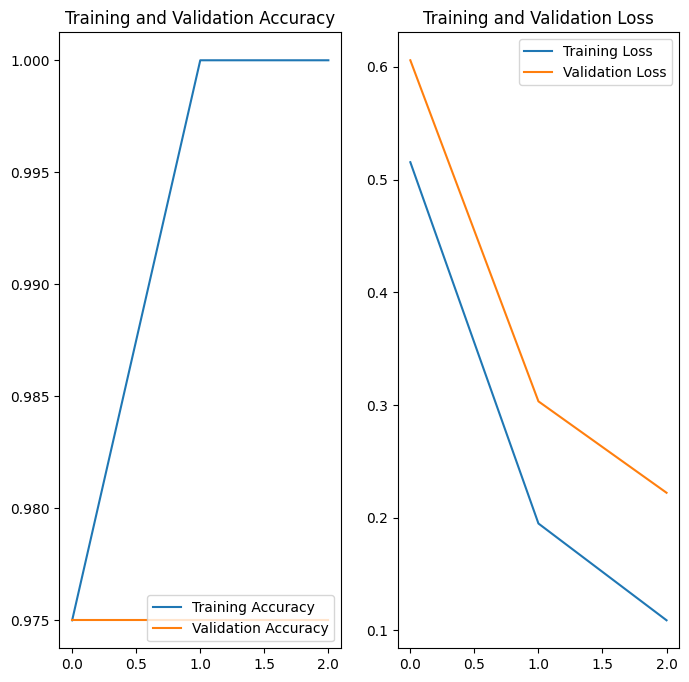

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 统计指标分析

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for x_img,x_img_clip, x_text,x_text_clip, x_vec,  y in test_dl:
  x_img,x_img_clip, x_text,x_text_clip,x_vec,  y = x_img.to(device),x_img_clip.to(device),x_text.to(device),x_text_clip.to(device), x_vec.to(device), y.to(device)

  # Compute prediction error
  # print(x_img.shape,x_text.shape)
  predict_score = big_model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
  # predict_score = big_model(b_img,b_text)
  predict_pro = m_softmax(predict_score)

  predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

  predict_pro_list.append(predict_pro.detach().cpu().numpy())
  predict_list.append(predict_label)
  label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.03286333, 0.93182683, 0.65648085, 0.02400152, 0.01775453],
       dtype=float32),
 array([0, 1, 1, 2, 0]),
 array([0, 1, 1, 2, 0]))

In [ ]:
np.unique(predict_array)

array([0, 1, 2, 3])

In [ ]:
len(np.unique(label_array))

4

### 分类报告

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.929     1.000     0.963        13
           1      1.000     1.000     1.000         6
           2      1.000     0.923     0.960        13
           3      1.000     1.000     1.000         8

    accuracy                          0.975        40
   macro avg      0.982     0.981     0.981        40
weighted avg      0.977     0.975     0.975        40



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[13,  0,  0,  0],
       [ 0,  6,  0,  0],
       [ 1,  0, 12,  0],
       [ 0,  0,  0,  8]])

<Axes: >

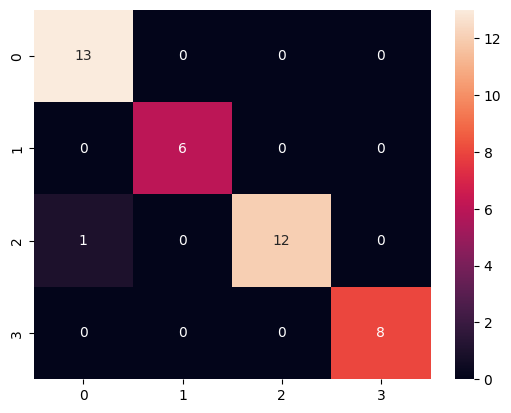

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

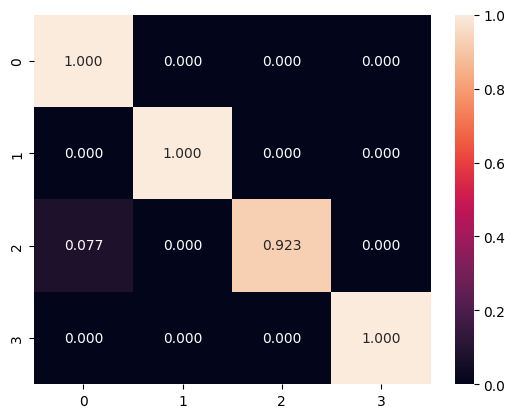

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型一： 基础版模型

## 准备训练和测试循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_img, x_text, x_vec,  y) in enumerate(dataloader):
        x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device), y.to(device)

        # Compute prediction error
        # print(x_img.shape,x_text.shape)
        pred = model(x_img, x_text, x_vec)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(x_img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x_img, x_text, x_vec,  y) in enumerate(dataloader):
            x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device),y.to(device)
            pred = model(x_img, x_text, x_vec)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## 数据处理和特征工程

### 英文编码tokenizer

In [ ]:
# tokenizer_en = Tokenizer.from_pretrained("bert-base-uncased")
model_name = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
eg_text = '$T$ triumphs at Manchester May Day Festival'
eg_result = tokenizer_bert(eg_text, padding='max_length', max_length=25, truncation=True, return_tensors="pt")
eg_result

{'input_ids': tensor([[  101,  1002,  1056,  1002, 10911,  2015,  2012,  5087,  2089,  2154,
          2782,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
voc_size = tokenizer_bert.vocab_size
voc_size

30522

### 准备dataset

In [ ]:
pd_all.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer_en):
        self.pd_data = pd_data
        self.text_list = list(pd_data['text'])
        self.label_list = list(pd_data['label'])
        self.img_path_list = list(pd_data['pic_path'])
        self.vec_lists = list(pd_all['vec'])
        self.tokenizer = tokenizer_en

    def __len__(self):
        # return len(self.label_list)
        return len(self.pd_data)

    def __getitem__(self, idx):
        # 文本数据处理
        one_text = self.text_list[idx]
        one_text_array = self.tokenizer(one_text, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")['input_ids'][0]

        # 图像数据处理
        one_path = self.img_path_list[idx]
        # one_path = img_dir + one_path
        img_tensor = read_image(one_path,mode=torchvision.io.ImageReadMode.RGB)
        img_tensor = transforms.Resize((224,224))(img_tensor).float()

        # 向量数据处理
        one_vec = self.vec_lists[idx]
        one_vec_tensor = torch.tensor(one_vec).float()


        # label数据处理
        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return img_tensor,one_text_array,one_vec_tensor, one_label


tran_ds = CustomDataset(pd_train[:train_num],tokenizer_bert)
test_ds = CustomDataset(pd_test[:test_num],tokenizer_bert)

tran_ds[1][0].shape,tran_ds[1][1].shape,len(tran_ds),len(test_ds)

(torch.Size([3, 224, 224]), torch.Size([40]), 160, 40)

In [ ]:
pd_train.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec,len
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]",90
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]",95
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]",97
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]",97
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]",106


### 准备dataloader

In [ ]:

train_dl = DataLoader(tran_ds, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [ ]:
len(test_dl.dataset)

40

In [ ]:
for b_img,b_text,b_vec,label in test_dl:
  print(b_text.shape)
  print(b_img.shape)
  print(b_vec.shape)
  print(label)
  break

torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3])
tensor([0, 1, 1, 2, 0, 1, 3, 2])


## 模型构建

### 图像数据处理

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ImageBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


img_block = ImageBlock().to(device)
print(img_block)
img_block(b_img.to(device)).shape

ImageBlock(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 文本数据处理

In [ ]:
class textCNN(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        n_class = 2
        kernels=[3,4,5]
        kernel_number=[150,150,150]
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(max_len, number, size,padding=size) for (size,number) in zip(kernels,kernel_number)])
        self.dropout=nn.Dropout(0.1)
        self.out = nn.Linear(sum(kernel_number), 100)

    def forward(self, x):
        x = self.embd(x)

        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.out(x)
        return x
text_cnn = textCNN().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

text_cnn(b_text.to(device)).shape

torch.Size([8, 100])

### 结构化数据处理

In [ ]:
class vecBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


vec_block = vecBlock().to(device)
print(vec_block)
vec_block(b_vec.to(device)).shape

vecBlock(
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 整体模型构建

In [ ]:
# Define model
class bigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.img_block = ImageBlock()
        self.text_block = textCNN()
        self.vec_block = vecBlock()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(300, 50)
        self.lin2 = nn.Linear(50, n_class)


    def forward(self, img,text,vec):
        x1 = self.img_block(img)
        x2 = self.text_block(text)
        x3 = self.vec_block(vec)

        x = torch.cat([x1,x2,x3],dim=1)
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.lin2(x)
        # x =
        return x
big_model = bigModel().to(device)
big_model(b_img.to(device),b_text.to(device),b_vec.to(device))

tensor([[-0.0763, -0.2660,  0.0543,  0.4040],
        [ 0.3335, -0.2798,  0.2039,  0.5558],
        [-0.0507, -0.4395,  0.2477,  0.1452],
        [ 0.0900, -0.1663,  0.2310,  0.3516],
        [ 0.0693, -0.0879,  0.2244,  0.6541],
        [-0.3441, -0.0706, -0.0105,  0.6299],
        [ 0.2742, -0.3713,  0.0189,  0.7975],
        [ 0.0541, -0.2488,  0.1594,  0.4180]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(big_model.parameters(), lr=1e-3)


## 训练和测试

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, big_model, loss_fn)
    test_loss, test_correct = test(test_dl, big_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.259468  [    0/  160]
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.385148 

Test Error: 
 Accuracy: 30.0%, Avg loss: 1.643189 

Epoch 2
-------------------------------
loss: 1.168394  [    0/  160]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.006122 

Test Error: 
 Accuracy: 20.0%, Avg loss: 1.361302 

Epoch 3
-------------------------------
loss: 1.313455  [    0/  160]
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.653340 

Test Error: 
 Accuracy: 50.0%, Avg loss: 1.128709 

Done!


## 可视化训练过程

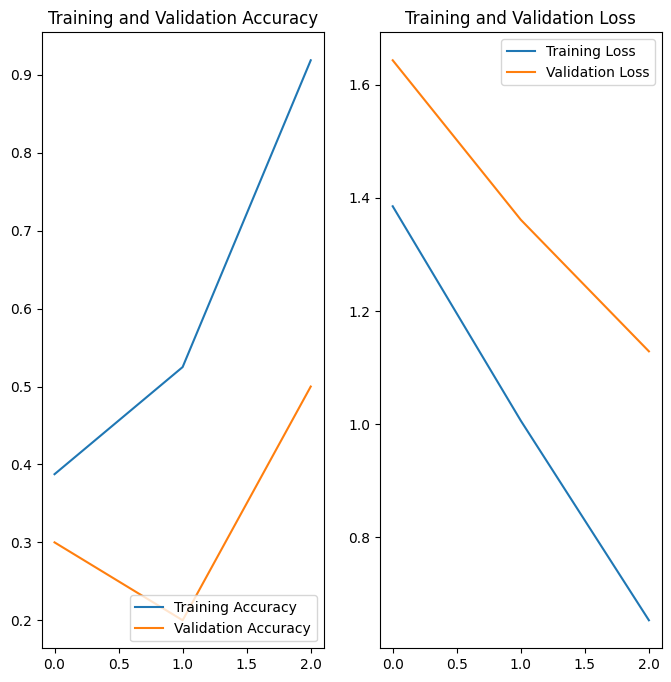

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 统计指标分析

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for x_img, x_text, x_vec,  y in test_dl:
  x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device), y.to(device)

  # Compute prediction error
  # print(x_img.shape,x_text.shape)
  predict_score = big_model(x_img, x_text, x_vec)
  # predict_score = big_model(b_img,b_text)
  predict_pro = m_softmax(predict_score)

  predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

  predict_pro_list.append(predict_pro.detach().cpu().numpy())
  predict_list.append(predict_label)
  label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.28833964, 0.29252046, 0.24316019, 0.21469384, 0.05317087],
       dtype=float32),
 array([0, 3, 0, 2, 3]),
 array([0, 1, 1, 2, 0]))

In [ ]:
np.unique(predict_array)

array([0, 1, 2, 3])

In [ ]:
len(np.unique(label_array))

4

### 分类报告

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.375     0.462     0.414        13
           1      0.500     0.333     0.400         6
           2      1.000     0.308     0.471        13
           3      0.500     1.000     0.667         8

    accuracy                          0.500        40
   macro avg      0.594     0.526     0.488        40
weighted avg      0.622     0.500     0.481        40



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[6, 1, 0, 6],
       [2, 2, 0, 2],
       [8, 1, 4, 0],
       [0, 0, 0, 8]])

<Axes: >

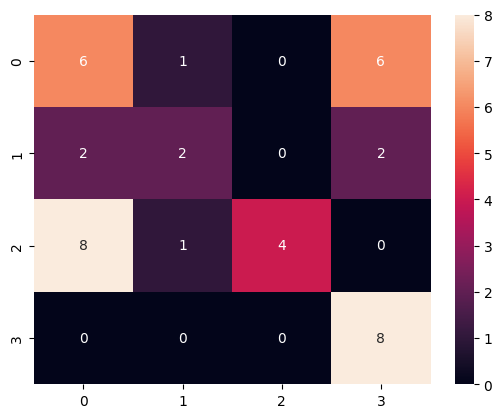

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

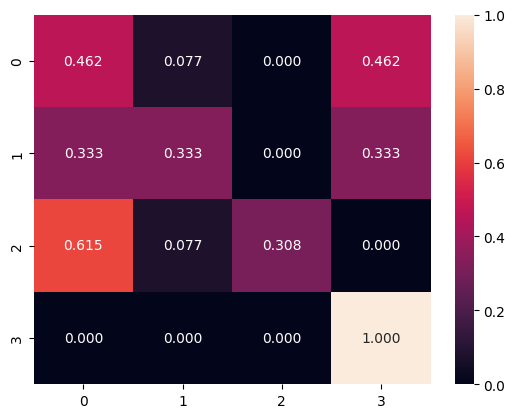

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型二： vit+cnn

## 准备训练和测试循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_img, x_text, x_vec,  y) in enumerate(dataloader):
        x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device), y.to(device)

        # Compute prediction error
        # print(x_img.shape,x_text.shape)
        pred = model(x_img, x_text, x_vec)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(x_img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x_img, x_text, x_vec,  y) in enumerate(dataloader):
            x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device),y.to(device)
            pred = model(x_img, x_text, x_vec)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## 数据处理和特征工程

### 英文编码tokenizer

In [ ]:
# tokenizer_en = Tokenizer.from_pretrained("bert-base-uncased")
model_name = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

In [ ]:
eg_text = '$T$ triumphs at Manchester May Day Festival'
eg_result = tokenizer_bert(eg_text, padding='max_length', max_length=25, truncation=True, return_tensors="pt")
eg_result

{'input_ids': tensor([[  101,  1002,  1056,  1002, 10911,  2015,  2012,  5087,  2089,  2154,
          2782,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
voc_size = tokenizer_bert.vocab_size
voc_size

30522

### 准备dataset

In [ ]:
pd_all.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer_en):
        self.pd_data = pd_data
        self.text_list = list(pd_data['text'])
        self.label_list = list(pd_data['label'])
        self.img_path_list = list(pd_data['pic_path'])
        self.vec_lists = list(pd_all['vec'])
        self.tokenizer = tokenizer_en

    def __len__(self):
        # return len(self.label_list)
        return len(self.pd_data)

    def __getitem__(self, idx):
        # 文本数据处理
        one_text = self.text_list[idx]
        one_text_array = self.tokenizer(one_text, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")['input_ids'][0]

        # 图像数据处理
        one_path = self.img_path_list[idx]
        # one_path = img_dir + one_path
        img_tensor = read_image(one_path,mode=torchvision.io.ImageReadMode.RGB)
        img_tensor = transforms.Resize((224,224))(img_tensor).float()

        # 向量数据处理
        one_vec = self.vec_lists[idx]
        one_vec_tensor = torch.tensor(one_vec).float()


        # label数据处理
        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return img_tensor,one_text_array,one_vec_tensor, one_label


tran_ds = CustomDataset(pd_train[:train_num],tokenizer_bert)
test_ds = CustomDataset(pd_test[:test_num],tokenizer_bert)

tran_ds[1][0].shape,tran_ds[1][1].shape,len(tran_ds),len(test_ds)

(torch.Size([3, 224, 224]), torch.Size([40]), 160, 40)

In [ ]:
pd_train.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec,len
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]",90
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]",95
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]",97
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]",97
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]",106


### 准备dataloader

In [ ]:

train_dl = DataLoader(tran_ds, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [ ]:
len(test_dl.dataset)

40

In [ ]:
for b_img,b_text,b_vec,label in test_dl:
  print(b_text.shape)
  print(b_img.shape)
  print(b_vec.shape)
  print(label)
  break

torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3])
tensor([0, 1, 1, 2, 0, 1, 3, 2])


## 模型构建

### 图像数据处理

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Image_vit(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model_vit = models.vit_b_16(pretrained=True)
        self.base_model_vit.heads.head = nn.Linear(768, 100)

    def forward(self, x):
        x = self.base_model_vit(x)
        return x

img_block = Image_vit().to(device)
# print(img_block)
img_block(b_img.to(device)).shape


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 100])

### 文本数据处理

In [ ]:
class textCNN(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        n_class = 2
        kernels=[3,4,5]
        kernel_number=[150,150,150]
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(max_len, number, size,padding=size) for (size,number) in zip(kernels,kernel_number)])
        self.dropout=nn.Dropout(0.1)
        self.out = nn.Linear(sum(kernel_number), 100)

    def forward(self, x):
        x = self.embd(x)

        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.out(x)
        return x
text_cnn = textCNN().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

text_cnn(b_text.to(device)).shape

torch.Size([8, 100])

### 结构化数据处理

In [ ]:
class vecBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


vec_block = vecBlock().to(device)
print(vec_block)
vec_block(b_vec.to(device)).shape

vecBlock(
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 整体模型构建

In [ ]:
# Define model
class bigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.img_block = ImageBlock()
        self.text_block = textCNN()
        self.vec_block = vecBlock()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(300, 50)
        self.lin2 = nn.Linear(50, n_class)


    def forward(self, img,text,vec):
        x1 = self.img_block(img)
        x2 = self.text_block(text)
        x3 = self.vec_block(vec)

        x = torch.cat([x1,x2,x3],dim=1)
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.lin2(x)
        # x =
        return x
big_model = bigModel().to(device)
big_model(b_img.to(device),b_text.to(device),b_vec.to(device)).shape

torch.Size([8, 4])

## 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(big_model.parameters(), lr=2e-5)


## 训练和测试

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, big_model, loss_fn)
    test_loss, test_correct = test(test_dl, big_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.313144  [    0/  160]
Test Error: 
 Accuracy: 40.6%, Avg loss: 1.274580 

Test Error: 
 Accuracy: 20.0%, Avg loss: 1.444825 

Epoch 2
-------------------------------
loss: 1.328422  [    0/  160]
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.184117 

Test Error: 
 Accuracy: 22.5%, Avg loss: 1.579448 

Epoch 3
-------------------------------
loss: 1.329836  [    0/  160]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.897367 

Test Error: 
 Accuracy: 32.5%, Avg loss: 1.336968 

Done!


## 可视化训练过程

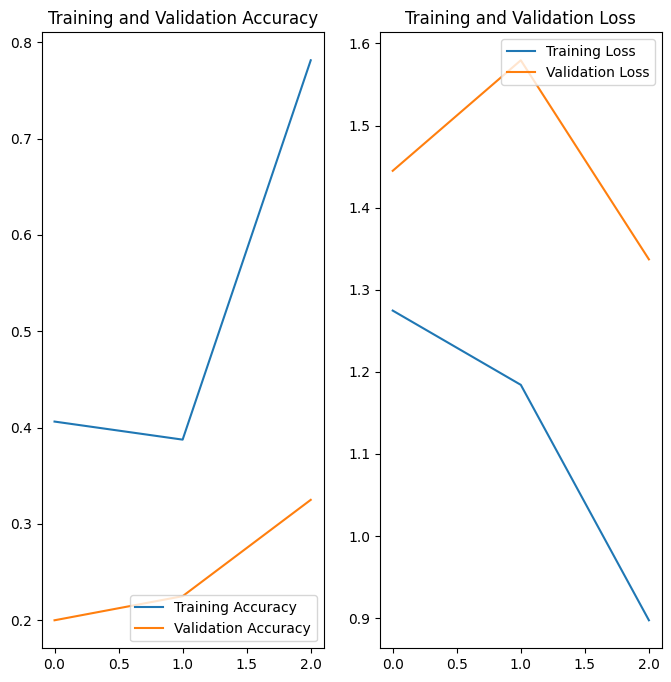

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 统计指标分析

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for x_img, x_text, x_vec,  y in test_dl:
  x_img, x_text,x_vec,  y = x_img.to(device),x_text.to(device), x_vec.to(device),y.to(device)

  # Compute prediction error
  # print(x_img.shape,x_text.shape)
  predict_score = big_model(x_img, x_text, x_vec)
  # predict_score = big_model(b_img,b_text)
  predict_pro = m_softmax(predict_score)

  predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

  predict_pro_list.append(predict_pro.detach().cpu().numpy())
  predict_list.append(predict_label)
  label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.21001454, 0.47832835, 0.2085748 , 0.21107423, 0.30708224],
       dtype=float32),
 array([3, 1, 0, 0, 1]),
 array([0, 1, 1, 2, 0]))

In [ ]:
np.unique(predict_array)

array([0, 1, 2, 3])

In [ ]:
len(np.unique(label_array))

4

### 分类报告

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.250     0.154     0.190        13
           1      0.167     0.500     0.250         6
           2      0.600     0.231     0.333        13
           3      0.556     0.625     0.588         8

    accuracy                          0.325        40
   macro avg      0.393     0.377     0.341        40
weighted avg      0.412     0.325     0.325        40



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[2, 7, 1, 3],
       [1, 3, 1, 1],
       [5, 5, 3, 0],
       [0, 3, 0, 5]])

<Axes: >

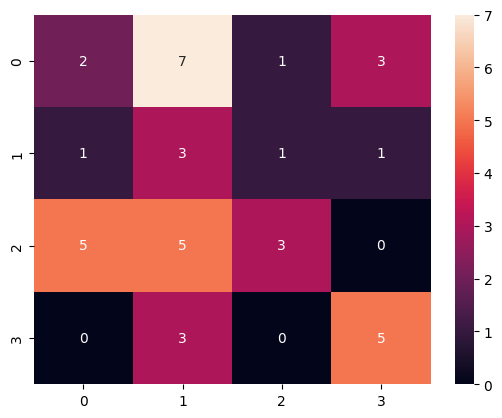

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

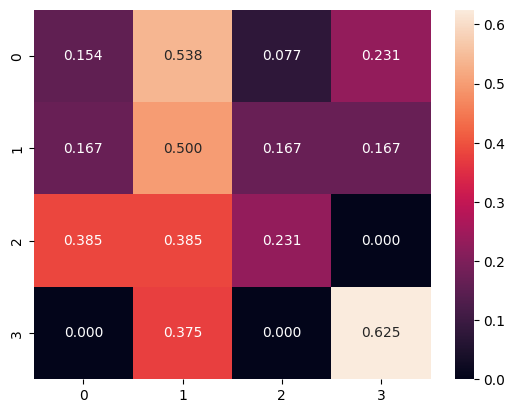

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型三： vit + bert + att + res

## 准备训练和测试循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec, y) in enumerate(dataloader):

        x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
        x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
        x_vec = x_vec.to(device)
        pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(x_img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec,  y) in enumerate(dataloader):
            x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
            x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
            x_vec = x_vec.to(device)
            pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## 数据处理和特征工程

### 英文编码tokenizer roberta

In [ ]:
model_name = "bert-base-chinese"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

In [ ]:
eg_text = '早上好'
eg_result = tokenizer_bert(eg_text, padding='max_length', max_length=25, truncation=True, return_tensors="pt")
eg_result

{'input_ids': tensor([[ 101, 3193,  677, 1962,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
voc_size = tokenizer_bert.vocab_size
voc_size

21128

### clip 文本处理

In [ ]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection

t_clip_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
t_clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# inputs = t_clip_tokenizer(["a photo of a cat", "a photo of a dog"],  return_tensors="pt",max_length=50,padding="max_length",truncation=True)
inputs = t_clip_tokenizer("a photo of a cat",  return_tensors="pt",max_length=50,padding="max_length",truncation=True)

outputs = t_clip_model(**inputs)
text_embeds = outputs.text_embeds

In [ ]:
text_embeds.shape

torch.Size([1, 512])

In [ ]:
inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
t_clip_model(inputs.input_ids).text_embeds

tensor([[ 1.5546e-01,  7.3294e-02, -2.4484e-01, -2.2115e-01, -1.9344e-01,
          2.0518e-01, -3.1749e-01, -7.8242e-01, -1.8164e-01,  1.9433e-01,
         -7.6181e-02, -6.0524e-01,  1.9231e-01, -1.0163e-01,  1.3738e-01,
          1.3672e-01,  2.4225e-01, -1.7962e-01, -8.8909e-02,  2.8717e-01,
          6.3450e-01,  1.6425e-01,  4.5428e-01, -2.9290e-02, -2.5141e-01,
          1.9239e-01,  2.4865e-01,  6.4663e-01, -2.3520e-01, -2.3172e-01,
          2.2597e-01,  1.8951e-01,  1.5041e-01,  4.8223e-01, -2.1912e-01,
         -1.8246e-01,  2.5335e-01, -2.7369e-02,  2.3673e-01,  2.3744e-01,
         -9.5580e-02, -1.1553e-01,  2.8116e-01,  1.1927e-01,  1.6268e-01,
          8.6734e-02, -2.5180e-01,  3.1935e-02, -5.3379e-02, -1.6613e-01,
          8.5413e-02, -4.0281e-02,  5.2349e-01, -9.5650e-02, -5.3954e-02,
         -2.9765e-01,  4.7326e-02,  2.0898e-01, -5.6442e-02, -3.0747e-02,
          4.5797e-01, -1.1969e-01, -2.9258e-01,  6.0592e-02,  2.1891e-01,
         -2.1244e-01,  3.9416e-02,  2.

### clip 图像处理

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModelWithProjection

img_clip_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
img_clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = img_clip_processor(images=image, return_tensors="pt")

outputs = img_clip_model(**inputs)
image_embeds = outputs.image_embeds

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [ ]:
outputs.image_embeds.shape

torch.Size([1, 512])

In [ ]:
pd_all.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"


### 准备dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer_en):
        self.pd_data = pd_data
        self.text_list = list(pd_data['text'])
        self.label_list = list(pd_data['label'])
        self.img_path_list = list(pd_data['pic_path'])
        self.vec_lists = list(pd_data['vec'])
        self.tokenizer = tokenizer_en
        self.t_clip_tokenizer = t_clip_tokenizer
        self.img_clip_processor = img_clip_processor

    def __len__(self):
        return len(self.pd_data)

    def __getitem__(self, idx):


        # 文本数据处理
        one_text = self.text_list[idx]
        one_text_array = self.tokenizer(one_text, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")['input_ids'][0]
        one_clip_text = self.t_clip_tokenizer(one_text,  return_tensors="pt",max_length=max_len,padding="max_length",truncation=True)['input_ids'][0]


        # 图像数据处理
        one_path = self.img_path_list[idx]
        # one_path = img_dir + one_path
        img_tensor = read_image(one_path,mode=torchvision.io.ImageReadMode.RGB)
        img_tensor = transforms.Resize((224,224))(img_tensor).float()

        image = Image.open(one_path).convert("RGB")
        one_clip_img = img_clip_processor(images=image, return_tensors="pt").pixel_values[0]


        # 向量数据处理
        one_vec = self.vec_lists[idx]
        one_vec_tensor = torch.tensor(one_vec).float()


        # label数据处理
        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return img_tensor, one_clip_img, one_text_array, one_clip_text, one_vec_tensor, one_label


tran_ds = CustomDataset(pd_train[:train_num],tokenizer_bert)
test_ds = CustomDataset(pd_test[:test_num],tokenizer_bert)

tran_ds[1][0].shape,tran_ds[1][1].shape,len(tran_ds),len(test_ds)

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), 160, 40)

### 准备dataloader

In [ ]:

train_dl = DataLoader(tran_ds, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [ ]:
len(test_dl.dataset)

40

In [ ]:
for b_img,b_img_clip, b_text,b_text_clip,b_vec,label in test_dl:
  print(b_text.shape)
  print(b_img.shape)
  print(b_text_clip.shape)
  print(b_img_clip.shape)
  print(b_vec.shape)
  print(label)
  break

torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3])
tensor([0, 1, 1, 2, 0, 1, 3, 2])


In [ ]:
b_vec

tensor([[0.1000, 0.3000, 0.6000],
        [0.2000, 0.6000, 0.2000],
        [0.0200, 0.0800, 0.9000],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.6000, 0.3000],
        [0.0500, 0.1000, 0.8500],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.2000, 0.7000]])

## 模型构建

### vit模块

In [ ]:
class Image_vit(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model_vit = models.vit_b_16(pretrained=True)
        self.base_model_vit.heads.head = nn.Linear(768, 100)

    def forward(self, x):
        x = self.base_model_vit(x)
        return x

vit_block = Image_vit().to(device)
# print(img_block)
vit_block(b_img.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 100])

### 文本数据处理

In [ ]:
class textBert(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=100).to(device)

    def forward(self, x):
        x = self.model(x)
        return x.logits
text_bert = textBert().to(device)

text_bert(b_text.to(device)).shape

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 100])

### 结构化数据处理

In [ ]:
class vecBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


vec_block = vecBlock().to(device)
print(vec_block)
vec_block(b_vec.to(device)).shape

vecBlock(
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 整体模型构建

In [ ]:
# Define model
class bigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.img_block = Image_vit()
        self.text_block = textBert()
        self.vec_block = vecBlock()

        self.img_clip_model = img_clip_model
        self.t_clip_model = t_clip_model
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(400, 50)
        self.lin2 = nn.Linear(50, n_class)
        self.lin_t = nn.Linear(512, 100)
        self.lin_i = nn.Linear(512, 100)
        self.att = nn.TransformerEncoderLayer(d_model=100,nhead=2)

    def forward(self, img,img_clip,text,text_clip,vec):
        x1 = self.img_block(img)
        # x4_img_clip = self.img_clip_model(img_clip).image_embeds
        # x4_img_clip = self.lin_i(x4_img_clip)

        x2 = self.text_block(text)
        # x5_t_clip = self.t_clip_model(text_clip).text_embeds
        # x5_t_clip = self.lin_t(x5_t_clip)

        x3 = self.vec_block(vec)

        x = torch.stack([x1,x2,x3],dim=1)
        x = self.att(x)

        x = self.flatten(x)

        x = torch.cat([x,x1],dim=1)
        x = self.lin1(x)
        x = self.lin2(x)
        # x =
        return x
big_model = bigModel().to(device)
big_model(b_img.to(device),b_img_clip.to(device),b_text.to(device),b_text_clip.to(device),b_vec.to(device)).shape

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 4])

## 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(big_model.parameters(), lr=2e-5)


## 训练和测试

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, big_model, loss_fn)
    test_loss, test_correct = test(test_dl, big_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.521816  [    0/  160]
Test Error: 
 Accuracy: 81.2%, Avg loss: 1.038352 

Test Error: 
 Accuracy: 75.0%, Avg loss: 1.072215 

Epoch 2
-------------------------------
loss: 1.076716  [    0/  160]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.648793 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.745354 

Epoch 3
-------------------------------
loss: 0.619815  [    0/  160]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.449287 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.621713 

Done!


## 可视化训练过程

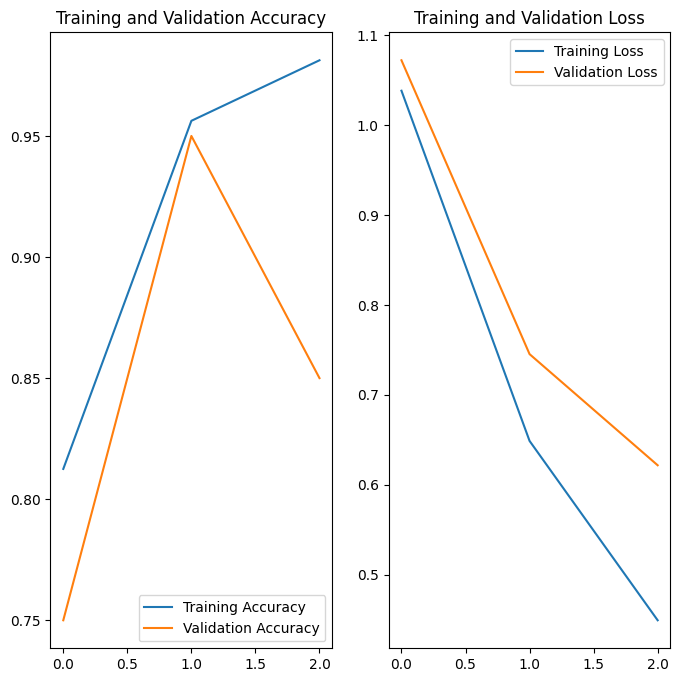

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 统计指标分析

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for x_img,x_img_clip, x_text,x_text_clip, x_vec,  y in test_dl:
  x_img,x_img_clip, x_text,x_text_clip,x_vec,  y = x_img.to(device),x_img_clip.to(device),x_text.to(device),x_text_clip.to(device), x_vec.to(device), y.to(device)

  # Compute prediction error
  # print(x_img.shape,x_text.shape)
  predict_score = big_model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
  # predict_score = big_model(b_img,b_text)
  predict_pro = m_softmax(predict_score)

  predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

  predict_pro_list.append(predict_pro.detach().cpu().numpy())
  predict_list.append(predict_label)
  label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.14844063, 0.48470438, 0.8014148 , 0.14587289, 0.11516815],
       dtype=float32),
 array([0, 1, 1, 2, 0]),
 array([0, 1, 1, 2, 0]))

In [ ]:
np.unique(predict_array)

array([0, 1, 2, 3])

In [ ]:
len(np.unique(label_array))

4

### 分类报告

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.750     0.923     0.828        13
           1      0.750     1.000     0.857         6
           2      1.000     0.615     0.762        13
           3      1.000     1.000     1.000         8

    accuracy                          0.850        40
   macro avg      0.875     0.885     0.862        40
weighted avg      0.881     0.850     0.845        40



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[12,  1,  0,  0],
       [ 0,  6,  0,  0],
       [ 4,  1,  8,  0],
       [ 0,  0,  0,  8]])

<Axes: >

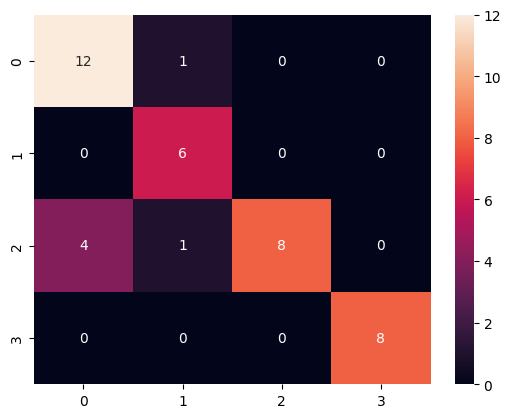

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

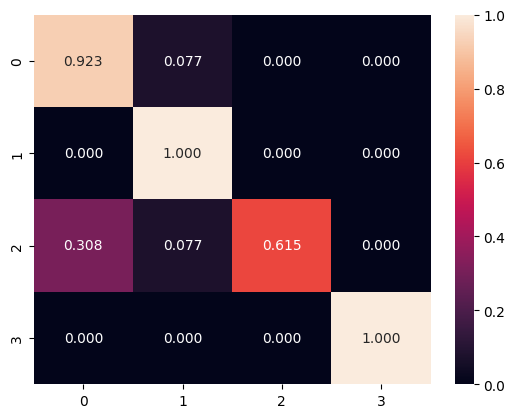

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型四： vit + bert + att

## 准备训练和测试循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec, y) in enumerate(dataloader):

        x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
        x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
        x_vec = x_vec.to(device)
        pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(x_img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x_img,x_img_clip, x_text,x_text_clip, x_vec,  y) in enumerate(dataloader):
            x_img, x_text, y = x_img.to(device),x_text.to(device), y.to(device)
            x_img_clip,x_text_clip = x_img_clip.to(device),x_text_clip.to(device)
            x_vec = x_vec.to(device)
            pred = model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## 数据处理和特征工程

### 英文编码tokenizer roberta

In [ ]:
model_name = "bert-base-chinese"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

In [ ]:
eg_text = '早上好'
eg_result = tokenizer_bert(eg_text, padding='max_length', max_length=25, truncation=True, return_tensors="pt")
eg_result

{'input_ids': tensor([[ 101, 3193,  677, 1962,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

In [ ]:
voc_size = tokenizer_bert.vocab_size
voc_size

21128

### clip 文本处理

In [ ]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection

t_clip_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
t_clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# inputs = t_clip_tokenizer(["a photo of a cat", "a photo of a dog"],  return_tensors="pt",max_length=50,padding="max_length",truncation=True)
inputs = t_clip_tokenizer("a photo of a cat",  return_tensors="pt",max_length=50,padding="max_length",truncation=True)

outputs = t_clip_model(**inputs)
text_embeds = outputs.text_embeds

In [ ]:
text_embeds.shape

torch.Size([1, 512])

In [ ]:
inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
t_clip_model(inputs.input_ids).text_embeds

tensor([[ 1.5546e-01,  7.3294e-02, -2.4484e-01, -2.2115e-01, -1.9344e-01,
          2.0518e-01, -3.1749e-01, -7.8242e-01, -1.8164e-01,  1.9433e-01,
         -7.6181e-02, -6.0524e-01,  1.9231e-01, -1.0163e-01,  1.3738e-01,
          1.3672e-01,  2.4225e-01, -1.7962e-01, -8.8909e-02,  2.8717e-01,
          6.3450e-01,  1.6425e-01,  4.5428e-01, -2.9290e-02, -2.5141e-01,
          1.9239e-01,  2.4865e-01,  6.4663e-01, -2.3520e-01, -2.3172e-01,
          2.2597e-01,  1.8951e-01,  1.5041e-01,  4.8223e-01, -2.1912e-01,
         -1.8246e-01,  2.5335e-01, -2.7369e-02,  2.3673e-01,  2.3744e-01,
         -9.5580e-02, -1.1553e-01,  2.8116e-01,  1.1927e-01,  1.6268e-01,
          8.6734e-02, -2.5180e-01,  3.1935e-02, -5.3379e-02, -1.6613e-01,
          8.5413e-02, -4.0281e-02,  5.2349e-01, -9.5650e-02, -5.3954e-02,
         -2.9765e-01,  4.7326e-02,  2.0898e-01, -5.6442e-02, -3.0747e-02,
          4.5797e-01, -1.1969e-01, -2.9258e-01,  6.0592e-02,  2.1891e-01,
         -2.1244e-01,  3.9416e-02,  2.

### clip 图像处理

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModelWithProjection

img_clip_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
img_clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = img_clip_processor(images=image, return_tensors="pt")

outputs = img_clip_model(**inputs)
image_embeds = outputs.image_embeds

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [ ]:
outputs.image_embeds.shape

torch.Size([1, 512])

In [ ]:
pd_all.head()

,Unnamed: 0,pic,label,text,score,pic_path,vec
0,108,/content/108.jpg,2,图片中，一个小孩悬挂在建筑物的边缘，身体悬空，显得非常危险。两名穿着制服的救援人员正在紧急拉...,"{'score':[0.05, 0.1, 0.85]}",/content/新建文件夹/108.jpg,"[0.05, 0.1, 0.85]"
1,4,/content/4.jpg,0,这张图片中，几名身穿迷彩服和防护装备的士兵正在建筑物内进行战斗。他们持枪瞄准前方，表情专注，...,"{'score':[0.05, 0.2, 0.75]}",/content/新建文件夹/4.jpg,"[0.05, 0.2, 0.75]"
2,64,/content/64.jpg,1,图片展示了一名光头男子，他身穿深色衣服，手持一把长刀，刀刃水平举起。背景是浅色的砖墙，整体环...,"{'score':[0.3, 0.6, 0.1]}",/content/新建文件夹/64.jpg,"[0.3, 0.6, 0.1]"
3,93,/content/93.jpg,1,图片中，一只手握着一把折叠刀，刀刃明亮。桌子上摆放着多种刀具，包括匕首、小刀、斧头和其他类型...,"{'score':[0.05, 0.3, 0.65]}",/content/新建文件夹/93.jpg,"[0.05, 0.3, 0.65]"
4,34,/content/34.jpg,0,图片中，几支步枪整齐地排列在木制桌面上。步枪的上方放着一面美国国旗，作为背景。步枪的设计和配...,"{'score':[0.2, 0.6, 0.2]}",/content/新建文件夹/34.jpg,"[0.2, 0.6, 0.2]"


### 准备dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer_en):
        self.pd_data = pd_data
        self.text_list = list(pd_data['text'])
        self.label_list = list(pd_data['label'])
        self.img_path_list = list(pd_data['pic_path'])
        self.vec_lists = list(pd_data['vec'])
        self.tokenizer = tokenizer_en
        self.t_clip_tokenizer = t_clip_tokenizer
        self.img_clip_processor = img_clip_processor

    def __len__(self):
        return len(self.pd_data)

    def __getitem__(self, idx):


        # 文本数据处理
        one_text = self.text_list[idx]
        one_text_array = self.tokenizer(one_text, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")['input_ids'][0]
        one_clip_text = self.t_clip_tokenizer(one_text,  return_tensors="pt",max_length=max_len,padding="max_length",truncation=True)['input_ids'][0]


        # 图像数据处理
        one_path = self.img_path_list[idx]
        # one_path = img_dir + one_path
        img_tensor = read_image(one_path,mode=torchvision.io.ImageReadMode.RGB)
        img_tensor = transforms.Resize((224,224))(img_tensor).float()

        image = Image.open(one_path).convert("RGB")
        one_clip_img = img_clip_processor(images=image, return_tensors="pt").pixel_values[0]


        # 向量数据处理
        one_vec = self.vec_lists[idx]
        one_vec_tensor = torch.tensor(one_vec).float()


        # label数据处理
        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return img_tensor, one_clip_img, one_text_array, one_clip_text, one_vec_tensor, one_label


tran_ds = CustomDataset(pd_train[:train_num],tokenizer_bert)
test_ds = CustomDataset(pd_test[:test_num],tokenizer_bert)

tran_ds[1][0].shape,tran_ds[1][1].shape,len(tran_ds),len(test_ds)

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), 160, 40)

### 准备dataloader

In [ ]:

train_dl = DataLoader(tran_ds, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [ ]:
len(test_dl.dataset)

40

In [ ]:
for b_img,b_img_clip, b_text,b_text_clip,b_vec,label in test_dl:
  print(b_text.shape)
  print(b_img.shape)
  print(b_text_clip.shape)
  print(b_img_clip.shape)
  print(b_vec.shape)
  print(label)
  break

torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 40])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3])
tensor([0, 1, 1, 2, 0, 1, 3, 2])


In [ ]:
b_vec

tensor([[0.1000, 0.3000, 0.6000],
        [0.2000, 0.6000, 0.2000],
        [0.0200, 0.0800, 0.9000],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.6000, 0.3000],
        [0.0500, 0.1000, 0.8500],
        [0.0500, 0.1000, 0.8500],
        [0.1000, 0.2000, 0.7000]])

## 模型构建

### vit模块

In [ ]:
class Image_vit(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model_vit = models.vit_b_16(pretrained=True)
        self.base_model_vit.heads.head = nn.Linear(768, 100)

    def forward(self, x):
        x = self.base_model_vit(x)
        return x

vit_block = Image_vit().to(device)
# print(img_block)
vit_block(b_img.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 100])

### 文本数据处理

In [ ]:
class textBert(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=100).to(device)

    def forward(self, x):
        x = self.model(x)
        return x.logits
text_bert = textBert().to(device)

text_bert(b_text.to(device)).shape

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 100])

### 结构化数据处理

In [ ]:
class vecBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


vec_block = vecBlock().to(device)
print(vec_block)
vec_block(b_vec.to(device)).shape

vecBlock(
  (fc1): Linear(in_features=3, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)


torch.Size([8, 100])

### 整体模型构建

In [ ]:
# Define model
class bigModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.img_block = Image_vit()
        self.text_block = textBert()
        self.vec_block = vecBlock()

        self.img_clip_model = img_clip_model
        self.t_clip_model = t_clip_model
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(300, 50)
        self.lin2 = nn.Linear(50, n_class)
        self.lin_t = nn.Linear(512, 100)
        self.lin_i = nn.Linear(512, 100)
        self.att = nn.TransformerEncoderLayer(d_model=100,nhead=2)

    def forward(self, img,img_clip,text,text_clip,vec):
        x1 = self.img_block(img)
        # x4_img_clip = self.img_clip_model(img_clip).image_embeds
        # x4_img_clip = self.lin_i(x4_img_clip)

        x2 = self.text_block(text)
        # x5_t_clip = self.t_clip_model(text_clip).text_embeds
        # x5_t_clip = self.lin_t(x5_t_clip)

        x3 = self.vec_block(vec)

        x = torch.stack([x1,x2,x3],dim=1)
        x = self.att(x)

        x = self.flatten(x)

        # x = torch.cat([x,x1],dim=1)
        x = self.lin1(x)
        x = self.lin2(x)
        # x =
        return x
big_model = bigModel().to(device)
big_model(b_img.to(device),b_img_clip.to(device),b_text.to(device),b_text_clip.to(device),b_vec.to(device)).shape

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([8, 4])

## 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(big_model.parameters(), lr=2e-5)


## 训练和测试

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, big_model, loss_fn)
    test_loss, test_correct = test(test_dl, big_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.437217  [    0/  160]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.028139 

Test Error: 
 Accuracy: 40.0%, Avg loss: 1.128768 

Epoch 2
-------------------------------
loss: 1.180700  [    0/  160]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.674353 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.747474 

Epoch 3
-------------------------------
loss: 0.640612  [    0/  160]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.433671 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.506340 

Done!


## 可视化训练过程

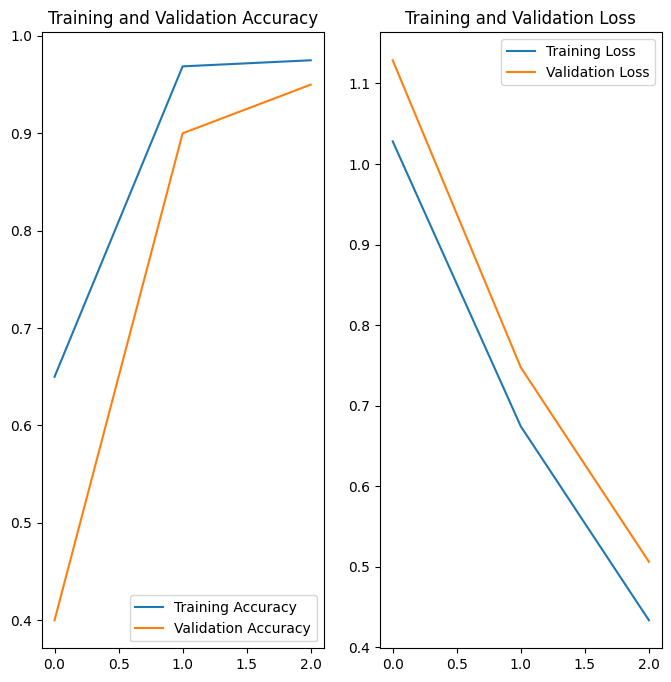

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 统计指标分析

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for x_img,x_img_clip, x_text,x_text_clip, x_vec,  y in test_dl:
  x_img,x_img_clip, x_text,x_text_clip,x_vec,  y = x_img.to(device),x_img_clip.to(device),x_text.to(device),x_text_clip.to(device), x_vec.to(device), y.to(device)

  # Compute prediction error
  # print(x_img.shape,x_text.shape)
  predict_score = big_model(x_img,x_img_clip, x_text,x_text_clip, x_vec)
  # predict_score = big_model(b_img,b_text)
  predict_pro = m_softmax(predict_score)

  predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

  predict_pro_list.append(predict_pro.detach().cpu().numpy())
  predict_list.append(predict_label)
  label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.15291443, 0.6755037 , 0.48352408, 0.12075513, 0.19059709],
       dtype=float32),
 array([0, 1, 1, 2, 0]),
 array([0, 1, 1, 2, 0]))

In [ ]:
np.unique(predict_array)

array([0, 1, 2, 3])

In [ ]:
len(np.unique(label_array))

4

### 分类报告

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      1.000     0.846     0.917        13
           1      0.857     1.000     0.923         6
           2      0.929     1.000     0.963        13
           3      1.000     1.000     1.000         8

    accuracy                          0.950        40
   macro avg      0.946     0.962     0.951        40
weighted avg      0.955     0.950     0.949        40



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[11,  1,  1,  0],
       [ 0,  6,  0,  0],
       [ 0,  0, 13,  0],
       [ 0,  0,  0,  8]])

<Axes: >

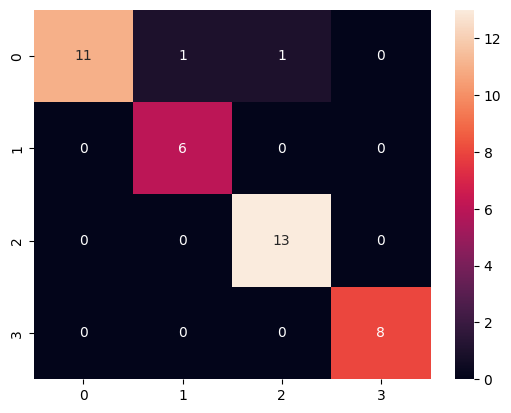

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

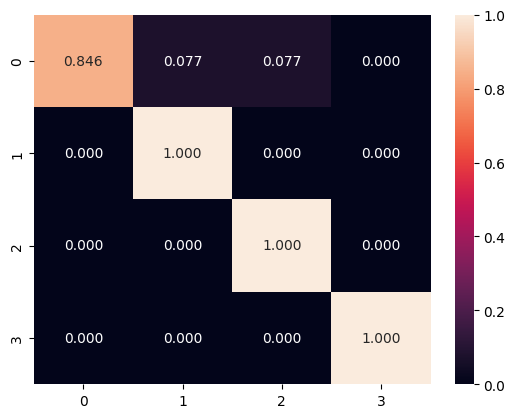

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')